# Data Exploration

## Setup

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.neighbors
import sklearn.ensemble
import sklearn.cluster
import sklearn.feature_selection
import matplotlib.pyplot as plt
import ast
import gensim, logging
import xgboost
import lightgbm
import datetime
import seaborn as sbn
import torch

C:\Users\caioj\Anaconda3\envs\forest-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
read_train_df = pd.read_csv('data/train.csv')
read_test_df = pd.read_csv('data/evaluation.csv')
read_train_df.describe()

,retweets_count,favorites_count,followers_count,statuses_count,friends_count,verified,timestamp,TweetID
count,353969.000000,353969.000000,3.539690e+05,3.539690e+05,353969.000000,353969.000000,3.539690e+05,3.539690e+05
mean,15.831810,46.655442,2.021548e+04,4.808507e+04,1459.289003,0.030005,1.647004e+12,6.872503e+05
std,241.986723,852.044385,2.598715e+05,1.133854e+05,2502.933271,0.170602,4.846468e+09,4.175793e+05
min,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,1.301178e+12,3.000000e+00
25%,0.000000,0.000000,1.600000e+02,2.972000e+03,214.000000,0.000000,1.647068e+12,3.194490e+05
50%,1.000000,0.000000,7.260000e+02,1.250100e+04,693.000000,0.000000,1.647292e+12,6.719730e+05
75%,3.000000,1.000000,2.283000e+03,4.352200e+04,1804.000000,0.000000,1.647532e+12,1.049644e+06
max,63674.000000,122591.000000,1.441710e+07,8.183508e+06,237269.000000,1.000000,1.647727e+12,1.434456e+06


In [3]:
read_train_df

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049
...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,[],1647438153000,142573
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,[],1647072106000,240866
353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,[],1647607230000,1173763
353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,[],1646987195000,929182


In [4]:
read_train_df['mentions'].apply(ast.literal_eval).apply(len).describe()

count    353969.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: mentions, dtype: float64

In [5]:
read_train_df.urls = read_train_df.urls.apply(ast.literal_eval)
read_train_df.hashtags = read_train_df.hashtags.apply(ast.literal_eval)

read_test_df.urls = read_test_df.urls.apply(ast.literal_eval)
read_test_df.hashtags = read_test_df.hashtags.apply(ast.literal_eval)

In [6]:
def format_df(df: pd.DataFrame,
                  type: str = 'train',
                  keep_time: bool = False):
    final_df = df.drop(['TweetID', 'mentions', 'timestamp'], axis=1)

    final_df['text'] = final_df['text'].apply(str.split)

    final_df['url_count'] = final_df.urls.apply(len)
    final_df['hashtag_count'] = final_df.hashtags.apply(len)

    if keep_time:
        timestamps = df.timestamp // 1000
        timestamps = timestamps.apply(datetime.datetime.fromtimestamp).apply(datetime.datetime.timetuple)

        time_df = pd.DataFrame(timestamps.tolist(), index=df.index,
                               columns=['tm_year', 'tm_mon', 'tm_mday', 'tm_hour', 'tm_min', 'tm_sec', 'tm_wday',
                                        'tm_yday', 'tm_isdst'])

        final_df = pd.concat([final_df, time_df], axis=1)

    return final_df

In [7]:
train_df = format_df(read_train_df, keep_time=True)
test_df = format_df(read_test_df, keep_time=True)

In [8]:
train_df

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,urls,verified,hashtags,url_count,hashtag_count,tm_year,tm_mon,tm_mday,tm_hour,tm_min,tm_sec,tm_wday,tm_yday,tm_isdst
0,"[rt, refarcir, macron, ans, nom, prépare]",3,0,3682,453535,3628,[],0,[],0,0,2022,3,11,6,54,8,4,70,-1
1,[populaire],0,0,86,1016,284,[],0,[],0,0,2022,3,19,13,51,28,5,78,-1
2,"[faut, dégager, cinglé]",3,1,1944,28234,1995,[],0,[],0,0,2022,3,15,19,47,28,1,74,-1
3,"[enseignants, mettre, prescriptions, président...",0,0,1,1072,0,[https://t.co/rytlted08g],0,[],1,0,2022,3,14,12,11,22,0,73,-1
4,"[mafieuse, oppressive, macron]",0,0,13957,25311,10841,[],0,[],0,0,2022,3,14,12,46,14,0,73,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,"[gonflette, tour, raciste, frustré]",0,0,34,1509,55,[https://t.co/pma33zhslx],0,[],1,0,2022,3,16,14,42,33,2,75,-1
353965,"[france, caste, crapuleuse, encadrée, gangster...",0,0,89,11166,127,[],0,[],0,0,2022,3,12,9,1,46,5,71,-1
353966,"[eric, zemmour, français, berbère]",3,0,1888,712,3086,[],0,[],0,0,2022,3,18,13,40,30,4,77,-1
353967,"[gauchistes, dépression, pq]",0,0,139,486,320,[],0,[],0,0,2022,3,11,9,26,35,4,70,-1


In [9]:
train_df_input = train_df.drop(['retweets_count', 'text', 'urls', 'hashtags'], axis=1)
train_df_input

,favorites_count,followers_count,statuses_count,friends_count,verified,url_count,hashtag_count,tm_year,tm_mon,tm_mday,tm_hour,tm_min,tm_sec,tm_wday,tm_yday,tm_isdst
0,0,3682,453535,3628,0,0,0,2022,3,11,6,54,8,4,70,-1
1,0,86,1016,284,0,0,0,2022,3,19,13,51,28,5,78,-1
2,1,1944,28234,1995,0,0,0,2022,3,15,19,47,28,1,74,-1
3,0,1,1072,0,0,1,0,2022,3,14,12,11,22,0,73,-1
4,0,13957,25311,10841,0,0,0,2022,3,14,12,46,14,0,73,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,0,34,1509,55,0,1,0,2022,3,16,14,42,33,2,75,-1
353965,0,89,11166,127,0,0,0,2022,3,12,9,1,46,5,71,-1
353966,0,1888,712,3086,0,0,0,2022,3,18,13,40,30,4,77,-1
353967,0,139,486,320,0,0,0,2022,3,11,9,26,35,4,70,-1


In [10]:
def score_dataset(X, y, model=xgboost.XGBRegressor()):
    score = sklearn.model_selection.cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_absolute_error'
    )
    score = - score.mean()
    return score

In [11]:
baseline_score = score_dataset(train_df_input.values, train_df['retweets_count'].values)
print(f'Baseline score: {baseline_score:.5f} MAE')

Baseline score: 6.68995 MAE


## Data Visualization, Feature Engineering

In [79]:
discrete_features = train_df_input.columns == 'verified'

mi_scores = sklearn.feature_selection.mutual_info_regression(train_df_input, train_df['retweets_count'], discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=train_df_input.columns)
mi_scores = mi_scores.sort_values(ascending=False)

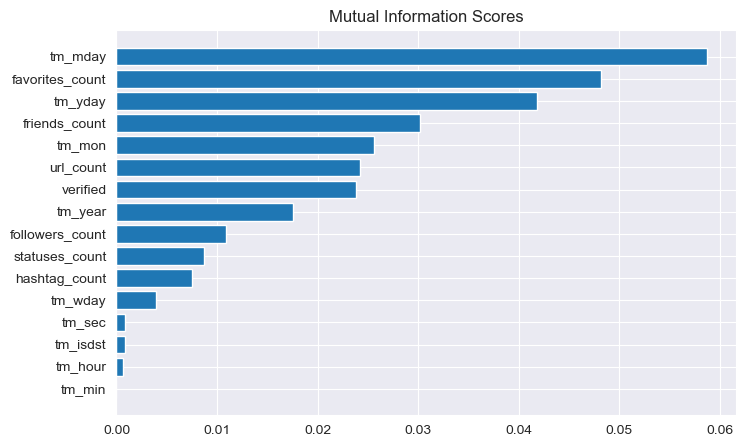

In [80]:
plt.figure(dpi=100, figsize=(8, 5))
mi_scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.show()

In [ ]:
new_train_df = train_df_input.drop(['tm_sec', 'tm_isdst'], axis=1)

In [ ]:
baseline_score = score_dataset(new_train_df.values, train_df['retweets_count'].values)
print(f'Baseline score: {baseline_score:.5f} MAE')

In [ ]:
fig, ax = plt.subplots(4, 2)

sbn.kdeplot(ax=ax[0, 0], data=train_df.favorites_count)
sbn.kdeplot(ax=ax[0, 1], data=np.log10(train_df.favorites_count).replace([-np.inf], -10))
sbn.kdeplot(ax=ax[1, 0], data=train_df.friends_count)
sbn.kdeplot(ax=ax[1, 1], data=np.log10(train_df.friends_count).replace([-np.inf], -10))
sbn.kdeplot(ax=ax[2, 0], data=train_df.followers_count)
sbn.kdeplot(ax=ax[2, 1], data=np.log10(train_df.followers_count).replace([-np.inf], -10))
sbn.kdeplot(ax=ax[3, 0], data=train_df.statuses_count)
sbn.kdeplot(ax=ax[3, 1], data=np.log10(train_df.statuses_count).replace([-np.inf], -10))

fig.tight_layout()
plt.show()

In [ ]:
new_train_df.favorites_count = np.log10(train_df_input.favorites_count).replace([-np.inf], -10)
new_train_df.friends_count = np.log10(train_df_input.friends_count).replace([-np.inf], -10)
new_train_df.followers_count = np.log10(train_df_input.followers_count).replace([-np.inf], -10)
new_train_df.statuses_count = np.log10(train_df_input.statuses_count).replace([-np.inf], -10)

In [ ]:
new_train_df

In [ ]:
baseline_score = score_dataset(new_train_df.values, train_df['retweets_count'].values)
print(f'Baseline score: {baseline_score:.5f} MAE')

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(new_train_df)

kmeans = sklearn.cluster.KMeans(n_clusters=9, random_state=0).fit(scaler.transform(new_train_df))

In [ ]:
for i in range(kmeans.n_clusters):
    mean_rtwts = train_df[kmeans.labels_ == i]['retweets_count'].mean()
    print(f'Cluster {i} mean retweets: {mean_rtwts}')

In [ ]:
new_train_df['cluster'] = kmeans.labels_
new_train_df['cluster'] = new_train_df['cluster'].astype('category')

In [ ]:
baseline_score = score_dataset(new_train_df.values, train_df['retweets_count'].values)
print(f'Baseline score: {baseline_score:.5f} MAE')

In [ ]:
hashtags_temp = train_df.explode('hashtags')[['hashtags', 'retweets_count']].groupby('hashtags').mean()
hashtags_temp

In [ ]:
retweet_hash_avg = hashtags_temp.to_dict()['retweets_count']
retweet_hash_avg

In [ ]:
def get_list_avg(list_obj):
    sum = 0
    for hash in list_obj:
        sum += retweet_hash_avg[hash] if hash in retweet_hash_avg else -1.0
    return sum / len(list_obj) if list_obj else -1.0

new_train_df['retweet_hash_avg'] = train_df['hashtags'].apply(get_list_avg)

In [ ]:
baseline_score = score_dataset(new_train_df.values, train_df['retweets_count'].values)
print(f'Baseline score: {baseline_score:.5f} MAE')

In [ ]:
test_hashs = test_df.explode('hashtags')['hashtags'].unique()[1:]
sum = 0
for i in range(len(test_hashs)):
    if test_hashs[i] in retweet_hash_avg:
        sum += 1
print(sum, len(test_hashs))

In [13]:
def feature_engineering(df: pd.DataFrame, type: str = 'train'):
    final_df = df.drop(['text', 'urls', 'hashtags', 'tm_sec', 'tm_isdst'], axis=1)
    if type == 'train':
        final_df = final_df.drop('retweets_count', axis=1)

    def has_rt(word_list):
        return int('rt' in word_list)
    final_df['has_rt'] = df['text'].apply(has_rt)



    return final_df

In [14]:
train_X = feature_engineering(train_df)
train_y = train_df['retweets_count']
test_X = feature_engineering(test_df, type='test')

In [15]:
train_X.columns

Index(['favorites_count', 'followers_count', 'statuses_count', 'friends_count',
       'verified', 'url_count', 'hashtag_count', 'tm_year', 'tm_mon',
       'tm_mday', 'tm_hour', 'tm_min', 'tm_wday', 'tm_yday', 'has_rt'],
      dtype='object')

# NLP

In [16]:
nlp_model = gensim.models.Word2Vec.load('models/word2vec.model')

train_tweets = read_train_df['text'].apply(str.split).to_list()
train_dictionary = gensim.corpora.Dictionary(train_tweets)
train_corpus = [train_dictionary.doc2bow(tweet) for tweet in train_tweets]

tfidf = gensim.models.TfidfModel(train_corpus)

In [17]:
text = read_train_df['text']

text_embed = np.zeros((len(text), nlp_model.vector_size))

for i in range(len(text)):
    encoded_words = [word for word in text.iloc[i].split(' ') if word in nlp_model.wv and
                     word in train_dictionary.token2id]
    if encoded_words:
        keys = [train_dictionary.token2id[word] for word in encoded_words]
        tf_idf_dict = dict(tfidf[train_corpus[i]])
        tf_idf_coefs = np.array([tf_idf_dict[key] for key in keys])

        text_vec = nlp_model.wv[encoded_words]
        text_vec = (text_vec * tf_idf_coefs[:, None]).sum(0)
    else:
        text_vec = np.zeros((nlp_model.vector_size, ))

    text_embed[i] = text_vec

text_embed

array([[-0.34097174, -0.75957348, -0.15579288, ...,  0.0065471 ,
        -0.52710954,  0.27569291],
       [ 0.3835026 , -0.98868424,  0.58028591, ..., -0.27867833,
        -0.58915681, -0.01707973],
       [ 0.04521481, -0.70911671,  0.48490373, ..., -0.26177776,
        -0.42644528,  0.41183245],
       ...,
       [ 0.08461105,  0.26366791,  0.21571769, ..., -0.00414332,
        -1.31368342,  0.14527826],
       [ 0.29872605, -0.81151386,  0.4763167 , ..., -0.35392145,
        -1.15688684,  0.35855108],
       [-0.5075289 , -0.66268525,  0.29968788, ..., -0.17514202,
        -0.74973956,  0.49627538]])

In [18]:
from models.conv1d_w2v_mlp import ConvWord2VecModel

In [19]:
conv_model = ConvWord2VecModel.load_from_checkpoint('checkpoints/Conv2_to8_W2V_256_tfidf_MLP_15fts_4_128_LR1e-3cosine72etaMin5e-5_AdamW_dropout0.3_hasRT_CV/checkpoints/epoch=62-split=0.ckpt')
conv_model.eval()

ConvWord2VecModel(
  (conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv1d(16, 16, kernel_size=(5,), stride=(2,))
    (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Conv1d(16, 64, kernel_size=(5,), stride=(1,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.3, inplace=False)
    (14): Conv1d(64, 64, kernel_size=(5,), stride=(2,))
    (15): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU()
    (17): Dropout(p=0.3, inp

In [20]:
kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True, random_state=12345)
all_splits = [i for i in kf.split(train_X)]
train_indexes, val_indexes = all_splits[0]

In [21]:
train_X_arr = train_X.values
scaler = sklearn.preprocessing.StandardScaler()
train_X_arr = scaler.fit_transform(train_X_arr)

In [22]:
train_X_arr = np.concatenate([train_X_arr, text_embed], axis=1)

In [23]:
input_dict = (torch.tensor(train_X_arr[val_indexes]), torch.tensor(train_y.values[val_indexes]))

In [24]:
val_results = conv_model(input_dict).detach().numpy()

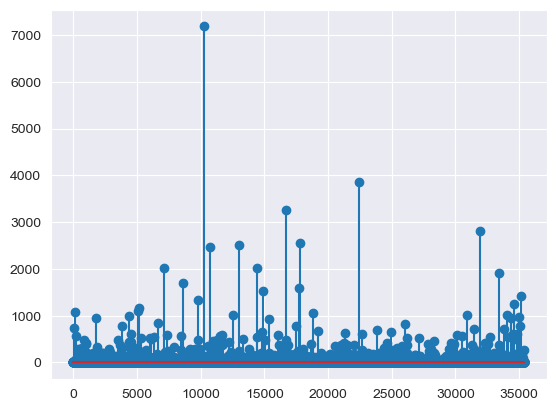

In [26]:
plt.stem(np.abs(val_results - train_y.values[val_indexes]))
plt.show()

In [25]:
np.abs(val_results - train_y.values[val_indexes]).mean()

5.476503286141309

In [68]:
gts = train_y.iloc[val_indexes][np.abs(val_results - train_y.values[val_indexes]) > 1000]
preds = val_results[np.abs(val_results - train_y.values[val_indexes]) > 1000]
error_analysis = pd.DataFrame(data={'gt': gts, 'pred': preds, 'ae': np.abs(gts - preds), 'mult': gts / preds},)

error_analysis

,gt,pred,ae,mult
1499,3168,2080.880615,1087.119385,1.522432
50796,2879,1768.038086,1110.961914,1.628359
51870,11654,10480.033203,1173.966797,1.112019
71897,3831,1805.702393,2025.297607,2.121612
86806,5893,7600.145508,1707.145508,0.775380
97881,1772,438.741669,1333.258331,4.038823
103039,36512,29328.304688,7183.695312,1.244941
107751,7782,5316.086914,2465.913086,1.463859
125744,1530,518.951660,1011.048340,2.948251
130573,3610,6116.443359,2506.443359,0.590212


In [49]:
error_analysis['mult'].mean(), error_analysis['mult'].std()

(1.6882035794946118, 1.0075940728672408)

In [53]:
read_train_df.iloc[val_indexes][np.abs(val_results - train_y.values[val_indexes]) > 1000]['favorites_count']

1499        5727
50796       8352
51870      16053
71897       6526
86806      35451
97881       2816
103039    117691
107751     17634
125744      1758
130573      7380
144509      1175
149275      4615
167711      8867
177781      4914
178362     27479
188332      3021
225418     57322
308986      6505
318995     38194
333850     10895
340174      3227
345894      2585
351100      4490
Name: favorites_count, dtype: int64

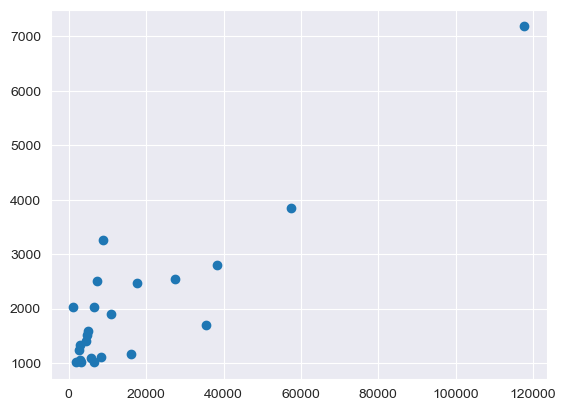

In [69]:
plt.scatter(read_train_df.iloc[val_indexes][np.abs(val_results - train_y.values[val_indexes]) > 1000]['favorites_count'], error_analysis['ae'])

In [70]:
fit = np.polyfit(read_train_df.iloc[val_indexes][np.abs(val_results - train_y.values[val_indexes]) > 1000]['favorites_count'], error_analysis['ae'], 1, )

fit

array([4.71934673e-02, 1.23182151e+03])

    # Make submission

In [ ]:
make_submission = True

if make_submission:
    test_ids = read_train_df['TweetID'].iloc[val_indexes]
    # model = xgboost.XGBRegressor(verbosity=1, max_depth=10)
    # model.fit(full_train_X, train_y)
    #
    # test_predictions = model.predict(full_test_X)

    submission_df = pd.DataFrame(data={'TweetID': test_ids, 'retweets_count': val_results})
    submission_df.to_csv('data/val_predictions.csv', index=False)

    print('Saved csv')